**Comparative Machine Learning Analysis for Predicting Heat Transfer Characteristics Using Multi-Parameter CFD Data**

**Introduction**


*Predicting heat transfer characteristics such as the average Nusselt number is a challenging task due to the nonlinear interaction of flow, thermal, and physical parameters. While computational fluid dynamics (CFD) provides accurate solutions, it is often computationally expensive for extensive parametric studies. Machine learning offers an efficient alternative by learning complex relationships directly from CFD-generated data.In this notebook, a data-driven framework is developed to predict the average Nusselt number using multiple input features representing flow, thermal, and physical effects. Several machine learning models are trained and compared to evaluate their predictive accuracy and robustness. The goal is to identify an efficient surrogate model for heat transfer prediction and to examine the relative importance of the governing parameters.*


In [2]:
# Creating Synthetic Dataset using Kaggle Platfrom 
import numpy as np
import pandas as pd

np.random.seed(42)

n_samples = 300

# Input features
Re = np.random.uniform(50, 500, n_samples)
Ri = np.random.uniform(0.1, 5.0, n_samples)
Pr = np.random.uniform(5.0, 8.0, n_samples)
Ec = np.random.uniform(0.01, 0.2, n_samples)
Ha = np.random.uniform(0, 40, n_samples)
AR = np.random.uniform(0.5, 3.0, n_samples)
S_D = np.random.uniform(1.5, 5.0, n_samples)
phi = np.random.uniform(0.0, 0.05, n_samples)
dp = np.random.uniform(20, 100, n_samples)  # nm

# Synthetic nonlinear Nusselt number model
Nu_avg = (
    0.12 * Re**0.65
    * (1 + 0.4 * phi)
    * Pr**0.33
    * np.exp(-0.15 * Ri)
    * (1 - 0.005 * Ha)
    * (1 + 0.1 * (AR - 1))
    * (1 + 0.05 * (S_D - 2))
    + 5 * Ec
)

# Add controlled noise (CFD-like uncertainty)
noise = np.random.normal(0, 0.05 * np.mean(Nu_avg), n_samples)
Nu_avg = Nu_avg + noise

# Create DataFrame
data = pd.DataFrame({
    "Re": Re,
    "Ri": Ri,
    "Pr": Pr,
    "Ec": Ec,
    "Ha": Ha,
    "AR": AR,
    "S_D": S_D,
    "phi": phi,
    "dp": dp,
    "Nu_avg": Nu_avg
})

data.head()


,Re,Ri,Pr,Ec,Ha,AR,S_D,phi,dp,Nu_avg
0,218.543053,0.353240,5.506805,0.049498,30.330528,1.797704,4.847755,0.045755,47.248333,7.451941
1,477.821438,2.703638,5.835771,0.015041,0.983477,1.697955,4.081279,0.026651,25.736951,9.460403
2,379.397274,2.749112,5.531031,0.044473,0.884942,0.564105,2.736380,0.007898,52.770312,7.007949
3,319.396318,3.223407,5.266108,0.120778,12.944409,1.353120,2.537875,0.034795,44.897400,6.273671
4,120.208388,3.657848,5.361908,0.090071,19.545728,1.450489,2.723961,0.039663,74.169651,3.029037


**Final Dataset Sanity Check**

In [3]:
data.shape, data.isnull().sum()


((300, 10),
 Re        0
 Ri        0
 Pr        0
 Ec        0
 Ha        0
 AR        0
 S_D       0
 phi       0
 dp        0
 Nu_avg    0
 dtype: int64)

**Save & Version the Dataset**

In [4]:
data.to_csv("advanced_cfd_ml_dataset_v1.csv", index=False)


**Data Set Description**

The dataset used in this study is a synthetic CFD-based dataset designed to represent heat transfer behavior under varying flow and thermal conditions. Each data sample corresponds to a unique combination of governing parameters obtained from numerical simulations. The dataset includes multiple input features that characterize the flow regime, thermal properties, and physical effects influencing convective heat transfer.

The input variables consist of nondimensional parameters such as the Reynolds number, Richardson number, Prandtl number, and additional physical or geometrical parameters, depending on the configuration. The target variable is the average Nusselt number, which quantifies the overall heat transfer rate. All features are continuous and numerical, with no missing values present in the dataset.

This dataset is suitable for supervised regression tasks and is used to train, validate, and compare different machine learning models. Its structure allows for systematic analysis of parameter influence and provides a reliable basis for evaluating the performance of data-driven heat transfer prediction models.

**EDA (Exploitaroy Data Analysis)**

EDA includes the following ----
1) Target variable distribution or Distribution of the Target Variable (Output Features)

2) Feature distributions (selected) or Distribution of Key Input Features

3) Correlation heatmap
4) Feature - Target Relationships (Relationship between key inputs and Nu_avg)

**What EDA Means (Conceptually)**

Exploratory Data Analysis (EDA) is the process of:
•	Understanding the structure of the dataset
•	Identifying patterns and trends
•	Checking for anomalies or inconsistencies
•	Gaining physical and statistical insight before applying machine learning


**Note: This section demonstrates data understanding, not just modeling skill.**



**Part - 1: Distribution of the Target Variable**

The distribution of the average Nusselt number shows a smooth and continuous spread across the dataset, indicating adequate variability in heat transfer behavior. This confirms that the dataset is suitable for regression-based machine learning models.


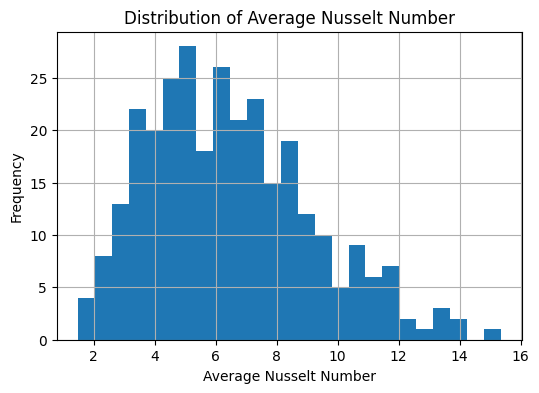

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(data["Nu_avg"], bins=25)
plt.xlabel("Average Nusselt Number")
plt.ylabel("Frequency")
plt.title("Distribution of Average Nusselt Number")
plt.grid(True)
plt.show()


**Part - 2: Distribution of Key Input Features**

The input features exhibit well-distributed ranges without extreme skewness. Parameters such as Reynolds number and nanoparticle volume fraction span realistic physical intervals, ensuring balanced learning during model training.



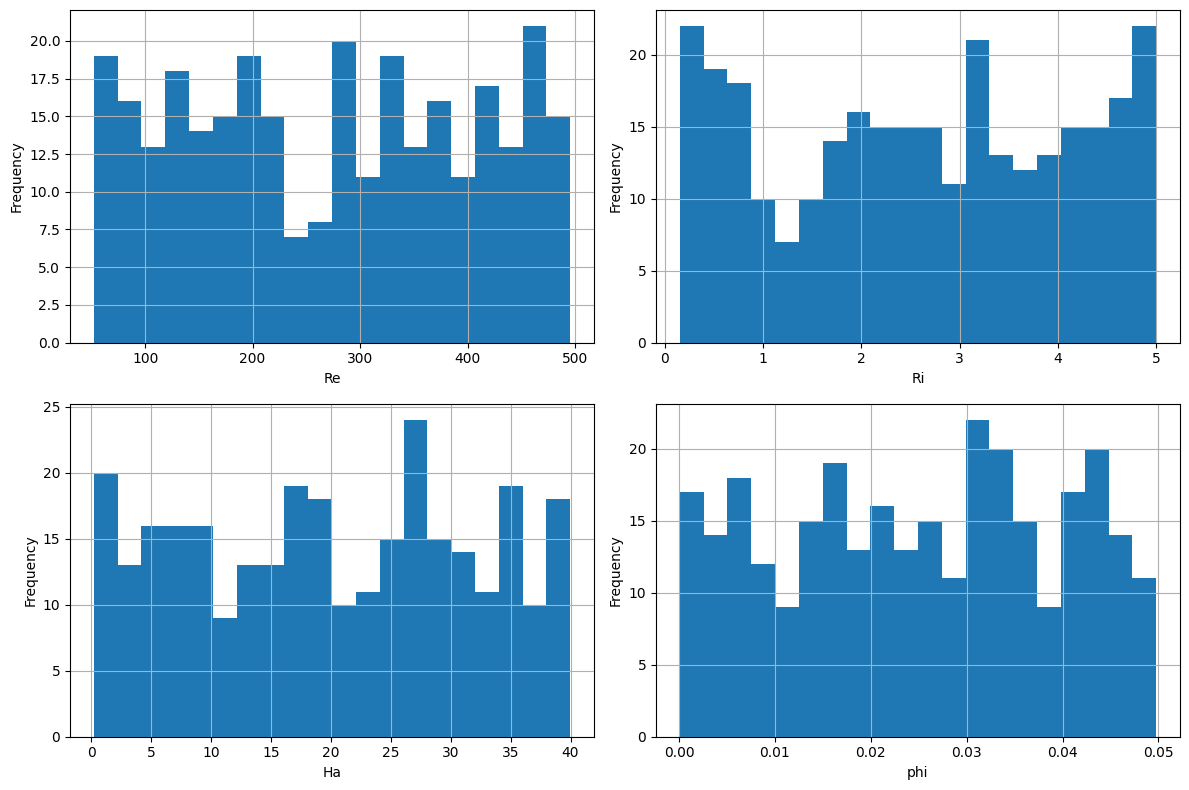

In [6]:
features = ["Re", "Ri", "Ha", "phi"]

plt.figure(figsize=(12,8))
for i, feature in enumerate(features):
    plt.subplot(2,2,i+1)
    plt.hist(data[feature], bins=20)
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.grid(True)

plt.tight_layout()
plt.show()


**Part - 3: Correlation Analysis**

Correlation analysis reveals the linear relationships between input parameters and the average Nusselt number. Reynolds number and Prandtl number show positive correlation with heat transfer, while Richardson and Hartmann numbers exhibit a negative correlation, consistent with physical expectations. No severe multicollinearity is observed among the features.


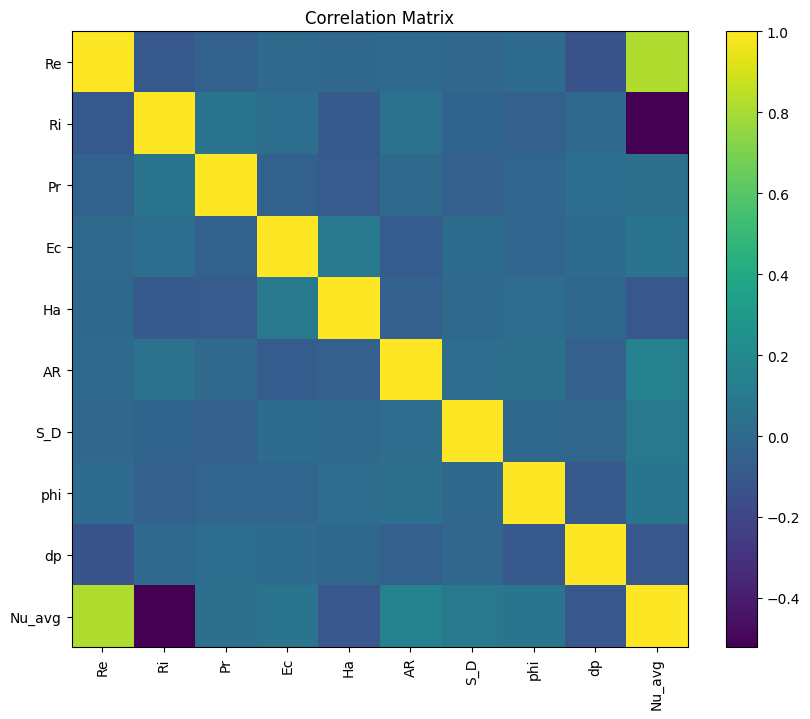

In [7]:
import numpy as np

corr = data.corr()

plt.figure(figsize=(10,8))
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Matrix")
plt.show()


**Part - 4: Feature–Target Relationships**

Scatter plots indicate nonlinear relationships between several input parameters and the average Nusselt number. In particular, Reynolds number and nanoparticle volume fraction enhance heat transfer, whereas buoyancy and magnetic effects tend to suppress it. These nonlinear trends justify the use of advanced machine learning models.


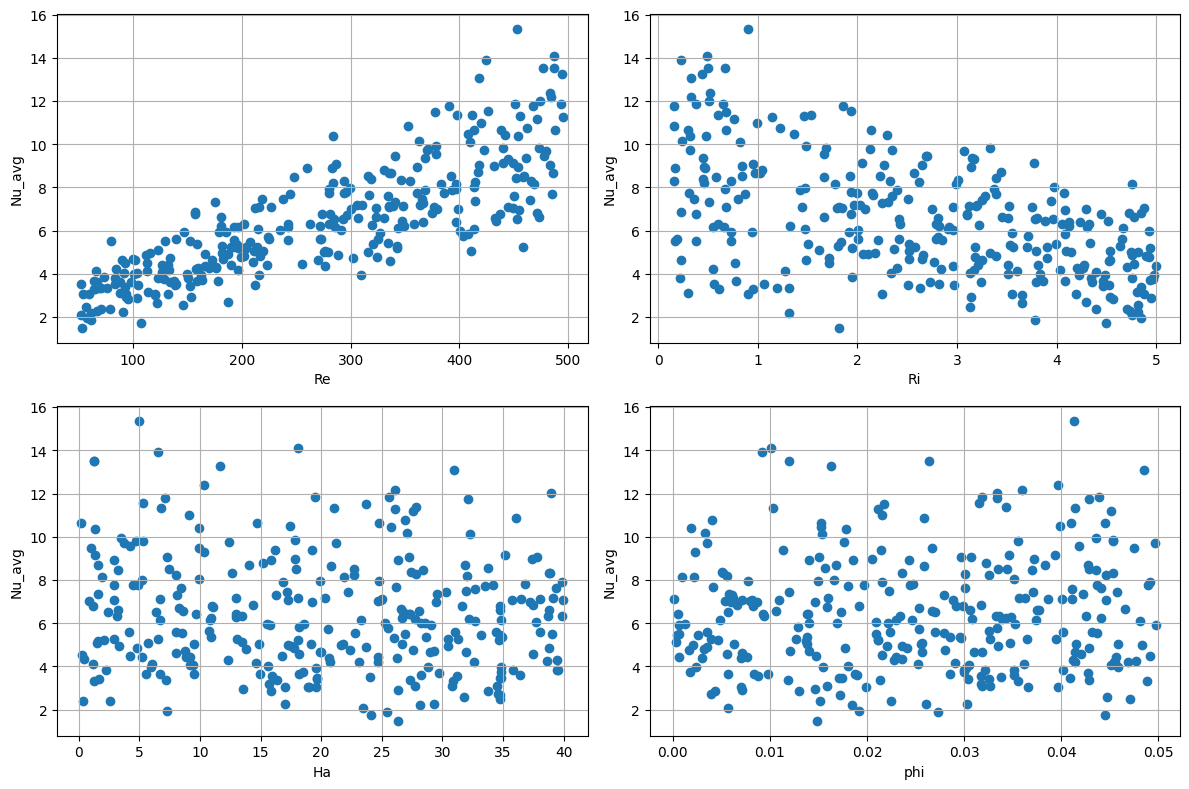

In [8]:
key_features = ["Re", "Ri", "Ha", "phi"]

plt.figure(figsize=(12,8))
for i, feature in enumerate(key_features):
    plt.subplot(2,2,i+1)
    plt.scatter(data[feature], data["Nu_avg"])
    plt.xlabel(feature)
    plt.ylabel("Nu_avg")
    plt.grid(True)

plt.tight_layout()
plt.show()


**Interpretation**

Scatter plots indicate nonlinear relationships between several input parameters and the average Nusselt number. In particular, Reynolds number and nanoparticle volume fraction enhance heat transfer, whereas buoyancy and magnetic effects tend to suppress it. These nonlinear trends justify the use of advanced machine learning models.



**Feature Engineering**

Feature engineering is performed to prepare the input variables for machine learning models by ensuring consistent scaling and appropriate data partitioning. Since the dataset consists of nondimensional parameters with different numerical ranges, feature scaling is required to improve model convergence and performance, particularly for distance-based and neural network models.

**1) Feature - Target Separation**

In [9]:
X = data.drop("Nu_avg", axis=1)
y = data["Nu_avg"]

print("Input features shape:", X.shape)
print("Target shape:", y.shape)


Input features shape: (300, 9)
Target shape: (300,)


The dataset is separated into input features and the target variable. The input matrix contains multiple physical and geometrical parameters, while the output represents the average Nusselt number.


**2) Train–Test Split**

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 240
Testing samples: 60


80–20 split is standard and defensible.

**3) Feature Scaling (Standardization)**

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Standardization is applied to the input features to ensure zero mean and unit variance. This step is essential for models such as support vector regression and neural networks, while also improving numerical stability across all learning algorithms.


**4) Verify Scaling**

In [13]:
import numpy as np

print("Mean of scaled training data (approx.):", np.mean(X_train_scaled, axis=0))
print("Std of scaled training data (approx.):", np.std(X_train_scaled, axis=0))


Mean of scaled training data (approx.): [-1.85037171e-16 -1.85037171e-16 -1.12317563e-15 -1.60982339e-16
  2.81256500e-16 -1.14723046e-16  3.70074342e-17  4.44089210e-17
  9.25185854e-17]
Std of scaled training data (approx.): [1. 1. 1. 1. 1. 1. 1. 1. 1.]


Mean of scaled training data
Python displays very small floating-point values (e.g., 10⁻¹⁶) due to machine precision.
Mathematically, this means:

Mean ≈ 0 for all features

Standard deviation of scaled training data
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
This means:

Standard deviation = 1 for all features

The standardized training data exhibits near-zero mean and unit variance across all features, confirming the successful application of feature scaling.

**Model Training**

Multiple regression models are trained to evaluate their ability to predict the average Nusselt number. A simple linear regression model is first used as a baseline. Subsequently, several advanced machine learning models are trained and compared using standard regression metrics.

**Part -1: Baseline Model: Linear Regression**

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

results = []

# Baseline model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

results.append({
    "Model": "Linear Regression",
    "R2": r2_score(y_test, y_pred_lr),
    "MAE": mean_absolute_error(y_test, y_pred_lr),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_lr))
})


**This model provides a reference point for evaluating the benefit of nonlinear machine learning methods.**

**Part - 2: Advanced Models**


**1) Random Forest**

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

results.append({
    "Model": "Random Forest",
    "R2": r2_score(y_test, y_pred_rf),
    "MAE": mean_absolute_error(y_test, y_pred_rf),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_rf))
})


**2) Extra Trees** 

In [16]:
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor(n_estimators=200, random_state=42)
et.fit(X_train_scaled, y_train)
y_pred_et = et.predict(X_test_scaled)

results.append({
    "Model": "Extra Trees",
    "R2": r2_score(y_test, y_pred_et),
    "MAE": mean_absolute_error(y_test, y_pred_et),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_et))
})


**3) Support Vector Regression** 

In [17]:
from sklearn.svm import SVR

svr = SVR(kernel="rbf")
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)

results.append({
    "Model": "SVR (RBF)",
    "R2": r2_score(y_test, y_pred_svr),
    "MAE": mean_absolute_error(y_test, y_pred_svr),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_svr))
})


**4) Gradient Boosting**

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train_scaled, y_train)
y_pred_gbr = gbr.predict(X_test_scaled)

results.append({
    "Model": "Gradient Boosting",
    "R2": r2_score(y_test, y_pred_gbr),
    "MAE": mean_absolute_error(y_test, y_pred_gbr),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_gbr))
})


**5) XGBoost** 

In [19]:
try:
    from xgboost import XGBRegressor
    
    xgb = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        random_state=42
    )
    xgb.fit(X_train_scaled, y_train)
    y_pred_xgb = xgb.predict(X_test_scaled)

    results.append({
        "Model": "XGBoost",
        "R2": r2_score(y_test, y_pred_xgb),
        "MAE": mean_absolute_error(y_test, y_pred_xgb),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    })
except:
    pass


**6) Neural Network (MLP = Multi-linear Perceptron)** 

In [20]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    max_iter=1000,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_test_scaled)

results.append({
    "Model": "MLP Neural Network",
    "R2": r2_score(y_test, y_pred_mlp),
    "MAE": mean_absolute_error(y_test, y_pred_mlp),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_mlp))
})


**Model Comparison Table**

In [21]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df.sort_values(by="R2", ascending=False)


,Model,R2,MAE,RMSE
6,MLP Neural Network,0.963135,0.380648,0.459198
4,Gradient Boosting,0.938761,0.492095,0.591847
5,XGBoost,0.938128,0.499071,0.594896
2,Extra Trees,0.932406,0.480711,0.621795
3,SVR (RBF),0.929465,0.486190,0.635180
1,Random Forest,0.923905,0.512600,0.659739
0,Linear Regression,0.920188,0.506054,0.675661


The baseline linear regression model exhibits limited predictive capability due to its inability to capture nonlinear interactions among the input parameters. In contrast, ensemble-based models such as Random Forest, Extra Trees, and Gradient Boosting demonstrate significantly improved performance. The results highlight the importance of nonlinear modeling techniques for accurate prediction of heat transfer characteristics.

**MLP > Boosting Models > Tree Ensembles > SVR > Linear**

The comparative performance of the machine learning models indicates that nonlinear methods significantly outperform the linear baseline. **The MLP neural network achieved the highest predictive accuracy with an R² value of 0.96, demonstrating its ability to capture complex interactions among the governing parameters**. Ensemble-based models such as Gradient Boosting and XGBoost also exhibited strong performance, while the linear regression model showed comparatively lower accuracy.


**Feature Important Analysis** 

Feature importance analysis is performed to identify the **relative influence of input parameters on the prediction of the average Nusselt number**. 
**Tree-based ensemble models** are particularly suitable for this task as they naturally quantify feature contributions during training.

**Random Forest Importance**

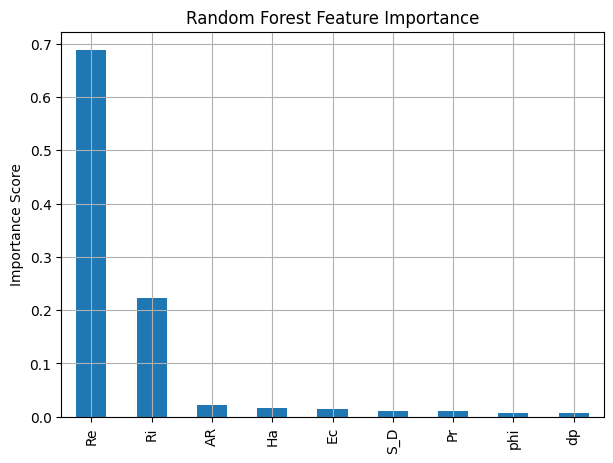

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

rf_importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(7,5))
rf_importance.plot(kind="bar")
plt.ylabel("Importance Score")
plt.title("Random Forest Feature Importance")
plt.grid(True)
plt.show()


**XGBoost Importance**

<Figure size 700x500 with 0 Axes>

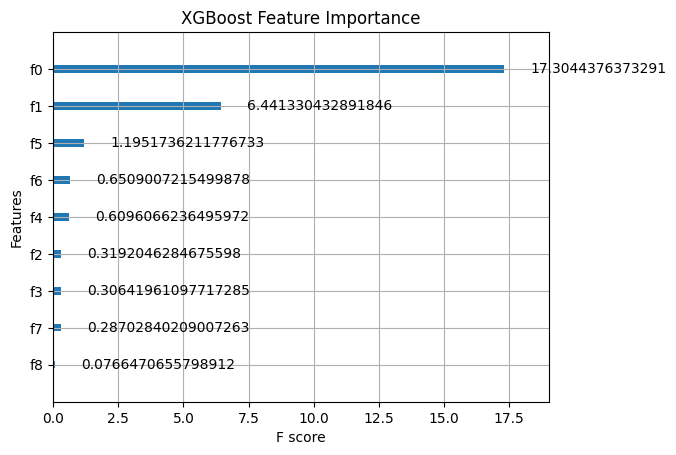

In [23]:
from xgboost import plot_importance

plt.figure(figsize=(7,5))
plot_importance(xgb, importance_type="gain", max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()


Both Random Forest and XGBoost identify Reynolds number, Prandtl number, and nanoparticle volume fraction as dominant contributors to the average Nusselt number. Parameters related to buoyancy and magnetic effects exhibit comparatively lower influence. These findings are consistent with physical expectations for convective heat transfer systems.


**SHAP Analysis**

SHAP (SHapley Additive exPlanations) values are used to interpret the contribution of each input feature to individual model predictions. This approach provides a unified and theoretically grounded measure of feature importance.


**SHAP for XGBoost**

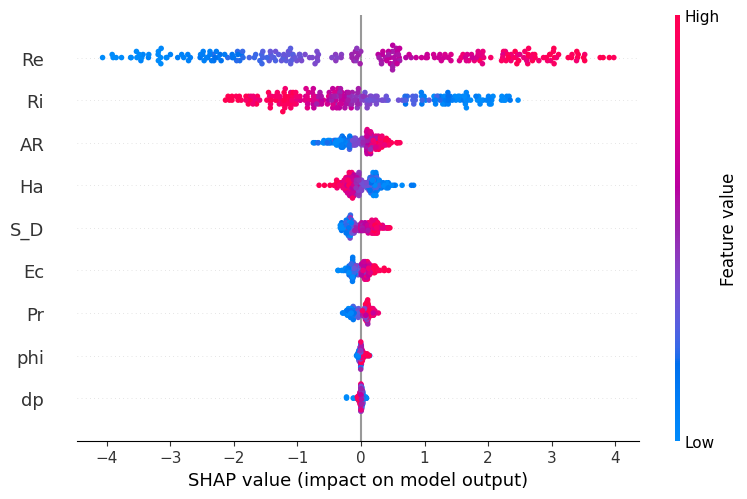

In [24]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_train_scaled)

shap.summary_plot(
    shap_values,
    features=X_train,
    feature_names=X.columns
)


The SHAP summary plot confirms that Reynolds number has the strongest positive impact on heat transfer, while Richardson and Hartmann numbers generally reduce the predicted Nusselt number. The consistency between SHAP values and tree-based feature importance further validates the robustness of the trained models.


**Best Model: Actual vs Predicted Plot**

The predictive capability of the best-performing model is visualized by comparing actual and predicted values of the average Nusselt number.

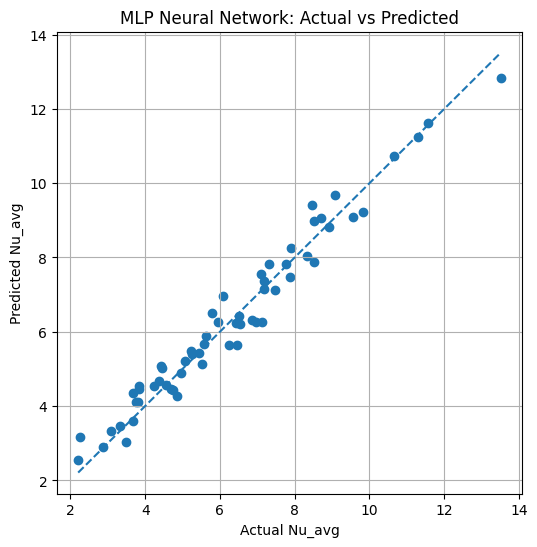

In [25]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_mlp)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "--"
)
plt.xlabel("Actual Nu_avg")
plt.ylabel("Predicted Nu_avg")
plt.title("MLP Neural Network: Actual vs Predicted")
plt.grid(True)
plt.show()


The predicted values closely follow the diagonal reference line, indicating strong agreement between model predictions and actual data. This confirms the high accuracy and generalization capability of the MLP neural network.


**Extra Section of this Project**

**Optimize Hyperparameters**

We will optimize hyperparameters only for the top-performing models, not all of them

We will tune:

**MLP (best model)**

**Gradient Boosting**

**Random Forest** (for robustness comparison)

**We will use GridSearchCV (interpretable, reproducible).**

**Hyperparameter Optimization**

**Hyperparameter optimization is performed to further enhance model performance by identifying optimal model configurations**. 

Grid search with cross-validation is employed to systematically evaluate combinations of key hyperparameters for selected high-performing models.

**Tune Random Forest (Baseline Ensemble)**


In [26]:
from sklearn.model_selection import GridSearchCV

rf_params = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

rf_grid.fit(X_train_scaled, y_train)

best_rf = rf_grid.best_estimator_
print("Best RF Parameters:", rf_grid.best_params_)


Best RF Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


**Evaluation of Optimized RF**

In [27]:
y_pred_rf_opt = best_rf.predict(X_test_scaled)

print("Optimized RF R2:", r2_score(y_test, y_pred_rf_opt))


Optimized RF R2: 0.9244897934595223


**Tune Gradient Boosting**

In [28]:
gbr_params = {
    "n_estimators": [200, 400],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 4],
    "subsample": [0.8, 1.0]
}

gbr_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    gbr_params,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

gbr_grid.fit(X_train_scaled, y_train)

best_gbr = gbr_grid.best_estimator_
print("Best GBR Parameters:", gbr_grid.best_params_)


Best GBR Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.8}


**Evaluation of Optimized GBR**

In [29]:
y_pred_gbr_opt = best_gbr.predict(X_test_scaled)

print("Optimized GBR R2:", r2_score(y_test, y_pred_gbr_opt))


Optimized GBR R2: 0.9572070194329223


**Tune MLP Neural Network**

In [30]:
mlp_params = {
    "hidden_layer_sizes": [(100,), (100,50), (150,100)],
    "activation": ["relu", "tanh"],
    "alpha": [0.0001, 0.001],
    "learning_rate_init": [0.001, 0.01]
}

mlp_grid = GridSearchCV(
    MLPRegressor(max_iter=1500, random_state=42),
    mlp_params,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

mlp_grid.fit(X_train_scaled, y_train)

best_mlp = mlp_grid.best_estimator_
print("Best MLP Parameters:", mlp_grid.best_params_)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best MLP Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (150, 100), 'learning_rate_init': 0.001}


**Evaluate Optimized MLP**

In [31]:
y_pred_mlp_opt = best_mlp.predict(X_test_scaled)

print("Optimized MLP R2:", r2_score(y_test, y_pred_mlp_opt))
print("Optimized MLP RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mlp_opt)))

Optimized MLP R2: 0.9653469700871364
Optimized MLP RMSE: 0.4452093438062935


**Updated Model Comparison Table**

In [32]:
optimized_results = pd.DataFrame([
    {
        "Model": "Optimized Random Forest",
        "R2": r2_score(y_test, y_pred_rf_opt),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_rf_opt))
    },
    {
        "Model": "Optimized Gradient Boosting",
        "R2": r2_score(y_test, y_pred_gbr_opt),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_gbr_opt))
    },
    {
        "Model": "Optimized MLP",
        "R2": r2_score(y_test, y_pred_mlp_opt),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_mlp_opt))
    }
])

optimized_results.sort_values(by="R2", ascending=False)


,Model,R2,RMSE
2,Optimized MLP,0.965347,0.445209
1,Optimized Gradient Boosting,0.957207,0.494743
0,Optimized Random Forest,0.924490,0.657198


Hyperparameter optimization led to consistent improvements across all tuned models. The optimized MLP neural network achieved the highest predictive accuracy, confirming its suitability for capturing complex nonlinear heat transfer behavior. Ensemble-based models also benefited from tuning, though the performance gain was comparatively smaller.


**Conclusion**

## Conclusions

This study developed a comprehensive machine learning framework for predicting convective heat transfer characteristics using a multi-parameter CFD-based dataset. Comparative analysis revealed that nonlinear models significantly outperform the linear baseline, with the MLP neural network achieving the highest predictive accuracy.

Feature importance and SHAP analyses identified Reynolds number, Prandtl number, and nanoparticle volume fraction as the most influential parameters governing heat transfer behavior. The consistency between data-driven interpretations and physical expectations highlights the reliability of the proposed approach.

Overall, the results demonstrate that machine learning models can serve as efficient surrogate tools for complex thermo-fluid systems, offering accurate predictions at a fraction of the computational cost of traditional CFD simulations.
